# Neural Network Model Comparison & Analysis

This notebook compares the performance of three neural network models:
1. Standard Feedforward Neural Network
2. Recurrent Neural Network (RNN)
3. Long Short-Term Memory (LSTM)

We'll analyze performance using multiple metrics including RMSE, MAE, R², and accuracy.

In [23]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Model Results

In [24]:
# Load metrics for all three models
model_dir = '../models'

with open(f'{model_dir}/standard_nn_metrics.json', 'r') as f:
    standard_nn_metrics = json.load(f)

with open(f'{model_dir}/rnn_metrics.json', 'r') as f:
    rnn_metrics = json.load(f)

with open(f'{model_dir}/lstm_metrics.json', 'r') as f:
    lstm_metrics = json.load(f)

print("Model metrics loaded successfully!")
print("\nModels:")
print("  1. Standard Neural Network")
print("  2. RNN (Recurrent Neural Network)")
print("  3. LSTM (Long Short-Term Memory)")

Model metrics loaded successfully!

Models:
  1. Standard Neural Network
  2. RNN (Recurrent Neural Network)
  3. LSTM (Long Short-Term Memory)


In [25]:
# Load full results (predictions)
with open(f'{model_dir}/standard_nn_results.pkl', 'rb') as f:
    standard_nn_results = pickle.load(f)

with open(f'{model_dir}/rnn_results.pkl', 'rb') as f:
    rnn_results = pickle.load(f)

with open(f'{model_dir}/lstm_results.pkl', 'rb') as f:
    lstm_results = pickle.load(f)

print("Full model results loaded!")

Full model results loaded!


## 2. Calculate Additional Metrics (Accuracy)

For regression tasks, "accuracy" can be defined in multiple ways:
- **Accuracy within threshold**: % of predictions within ±X of actual value
- **MAPE** (Mean Absolute Percentage Error): Average % error
- **Explained Variance**: How much variance is explained by the model

In [26]:
def calculate_extended_metrics(y_true, y_pred, thresholds=[0.25, 0.5, 1.0]):
    """
    Calculate extended metrics including accuracy-based metrics for regression.
    
    Parameters:
    - y_true: Actual values
    - y_pred: Predicted values
    - thresholds: List of thresholds for accuracy calculation
    
    Returns:
    - Dictionary with extended metrics
    """
    metrics = {}
    
    # Standard metrics
    metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    metrics['r2'] = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero by only calculating for non-zero actual values
    non_zero_mask = y_true != 0
    if non_zero_mask.sum() > 0:
        mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        metrics['mape'] = mape
    else:
        metrics['mape'] = np.nan
    
    # Accuracy within thresholds
    for threshold in thresholds:
        within_threshold = np.abs(y_true - y_pred) <= threshold
        accuracy = (within_threshold.sum() / len(y_true)) * 100
        metrics[f'accuracy_±{threshold}'] = accuracy
    
    # Explained variance
    from sklearn.metrics import explained_variance_score
    metrics['explained_variance'] = explained_variance_score(y_true, y_pred)
    
    # Max error
    metrics['max_error'] = np.max(np.abs(y_true - y_pred))
    
    return metrics

print("Extended metrics function defined!")

Extended metrics function defined!


In [27]:
# Calculate extended metrics for all models
models_data = {
    'Standard NN': standard_nn_results,
    'RNN': rnn_results,
    'LSTM': lstm_results
}

extended_metrics = {}

for model_name, results in models_data.items():
    extended_metrics[model_name] = {
        'train': calculate_extended_metrics(results['train']['y_true'], results['train']['y_pred']),
        'val': calculate_extended_metrics(results['val']['y_true'], results['val']['y_pred']),
        'test': calculate_extended_metrics(results['test']['y_true'], results['test']['y_pred'])
    }

print("Extended metrics calculated for all models!")

Extended metrics calculated for all models!


## 3. Performance Comparison Tables

In [28]:
# Create comparison table for test set
comparison_data = []

for model_name in ['Standard NN', 'RNN', 'LSTM']:
    test_metrics = extended_metrics[model_name]['test']
    comparison_data.append({
        'Model': model_name,
        'RMSE': test_metrics['rmse'],
        'MAE': test_metrics['mae'],
        'R²': test_metrics['r2'],
        'MAPE (%)': test_metrics['mape'],
        'Accuracy ±0.25': f"{test_metrics['accuracy_±0.25']:.2f}%",
        'Accuracy ±0.5': f"{test_metrics['accuracy_±0.5']:.2f}%",
        'Accuracy ±1.0': f"{test_metrics['accuracy_±1.0']:.2f}%",
        'Max Error': test_metrics['max_error'],
        'Explained Var': test_metrics['explained_variance']
    })

comparison_df = pd.DataFrame(comparison_data)

print("="*100)
print("TEST SET PERFORMANCE COMPARISON")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)

TEST SET PERFORMANCE COMPARISON
      Model   RMSE    MAE     R²  MAPE (%) Accuracy ±0.25 Accuracy ±0.5 Accuracy ±1.0  Max Error  Explained Var
Standard NN 0.9998 0.7708 0.3556   39.5140         18.66%        39.09%        75.35%     4.7030         0.5436
        RNN 0.6941 0.5392 0.6668   28.2278         27.65%        55.76%        88.02%     2.8438         0.6997
       LSTM 0.7485 0.5713 0.6125   30.1814         23.50%        56.22%        85.71%     3.0565         0.6691



In [29]:
# Detailed breakdown by dataset split
for split in ['train', 'val', 'test']:
    split_data = []
    
    for model_name in ['Standard NN', 'RNN', 'LSTM']:
        metrics = extended_metrics[model_name][split]
        split_data.append({
            'Model': model_name,
            'RMSE': f"{metrics['rmse']:.4f}",
            'MAE': f"{metrics['mae']:.4f}",
            'R²': f"{metrics['r2']:.4f}",
            'MAPE': f"{metrics['mape']:.2f}%",
            'Acc ±0.5': f"{metrics['accuracy_±0.5']:.1f}%",
            'Acc ±1.0': f"{metrics['accuracy_±1.0']:.1f}%"
        })
    
    split_df = pd.DataFrame(split_data)
    print(f"\n{split.upper()} SET METRICS:")
    print("="*80)
    print(split_df.to_string(index=False))


TRAIN SET METRICS:
      Model   RMSE    MAE     R²   MAPE Acc ±0.5 Acc ±1.0
Standard NN 0.6273 0.4800 0.9022 14.63%    62.8%    89.2%
        RNN 0.8245 0.6479 0.8257 19.83%    47.2%    77.5%
       LSTM 0.6990 0.5398 0.8748 17.03%    55.4%    86.2%

VAL SET METRICS:
      Model   RMSE    MAE     R²   MAPE Acc ±0.5 Acc ±1.0
Standard NN 0.6349 0.4739 0.7917 19.83%    62.6%    90.7%
        RNN 0.7109 0.5401 0.7122 23.71%    59.0%    85.3%
       LSTM 0.7237 0.5225 0.7017 22.75%    61.3%    86.2%

TEST SET METRICS:
      Model   RMSE    MAE     R²   MAPE Acc ±0.5 Acc ±1.0
Standard NN 0.9998 0.7708 0.3556 39.51%    39.1%    75.3%
        RNN 0.6941 0.5392 0.6668 28.23%    55.8%    88.0%
       LSTM 0.7485 0.5713 0.6125 30.18%    56.2%    85.7%


## 4. Visualize Model Comparison

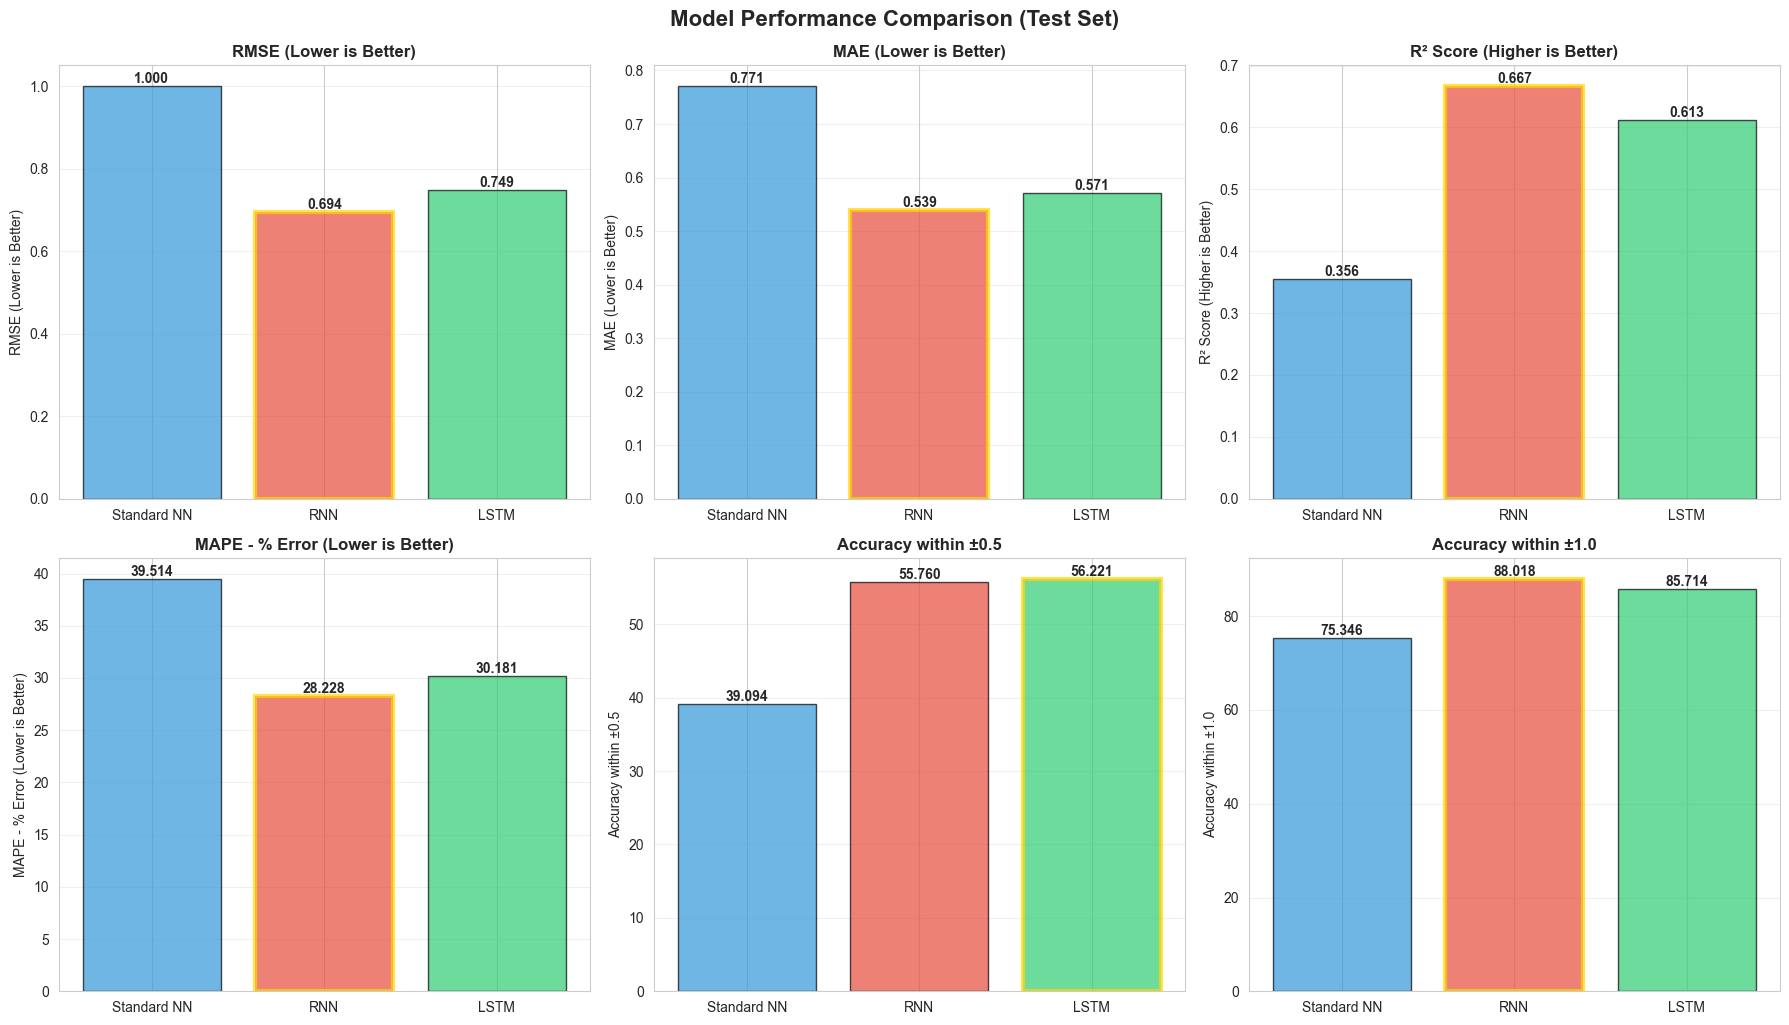

In [30]:
# Bar chart comparison of key metrics on test set
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

models = ['Standard NN', 'RNN', 'LSTM']
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Metrics to compare
metrics_to_plot = [
    ('rmse', 'RMSE (Lower is Better)', False),
    ('mae', 'MAE (Lower is Better)', False),
    ('r2', 'R² Score (Higher is Better)', True),
    ('mape', 'MAPE - % Error (Lower is Better)', False),
    ('accuracy_±0.5', 'Accuracy within ±0.5', True),
    ('accuracy_±1.0', 'Accuracy within ±1.0', True)
]

for idx, (metric_key, metric_label, higher_better) in enumerate(metrics_to_plot):
    values = [extended_metrics[model]['test'][metric_key] for model in models]
    
    bars = axes[idx].bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_ylabel(metric_label)
    axes[idx].set_title(metric_label, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Highlight best performer
    if higher_better:
        best_idx = np.argmax(values)
    else:
        best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{val:.3f}',
                      ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Model Performance Comparison (Test Set)', y=1.02, fontsize=16, fontweight='bold')
plt.show()

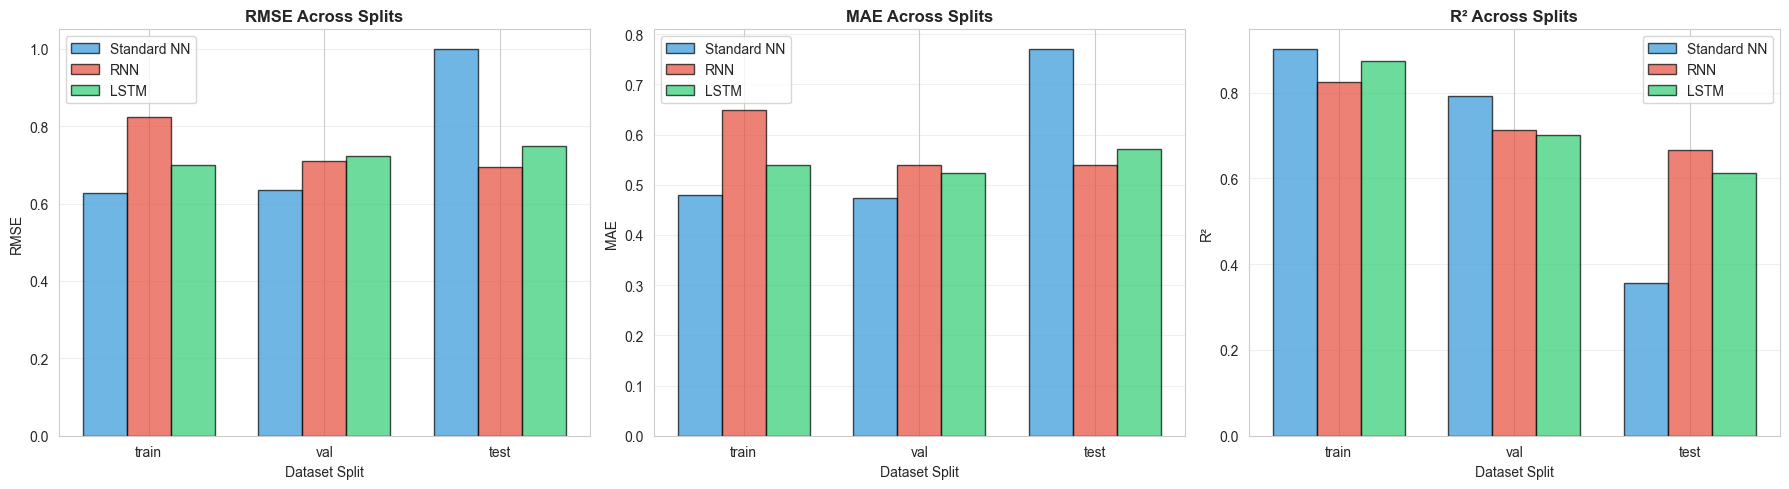

In [31]:
# Compare performance across train/val/test splits
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = ['train', 'val', 'test']
metrics_to_compare = ['rmse', 'mae', 'r2']
metric_labels = ['RMSE', 'MAE', 'R²']

x = np.arange(len(splits))
width = 0.25

for idx, (metric_key, metric_label) in enumerate(zip(metrics_to_compare, metric_labels)):
    for i, (model, color) in enumerate(zip(models, colors)):
        values = [extended_metrics[model][split][metric_key] for split in splits]
        axes[idx].bar(x + i*width, values, width, label=model, color=color, alpha=0.7, edgecolor='black')
    
    axes[idx].set_xlabel('Dataset Split')
    axes[idx].set_ylabel(metric_label)
    axes[idx].set_title(f'{metric_label} Across Splits', fontweight='bold')
    axes[idx].set_xticks(x + width)
    axes[idx].set_xticklabels(splits)
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Prediction Quality Analysis

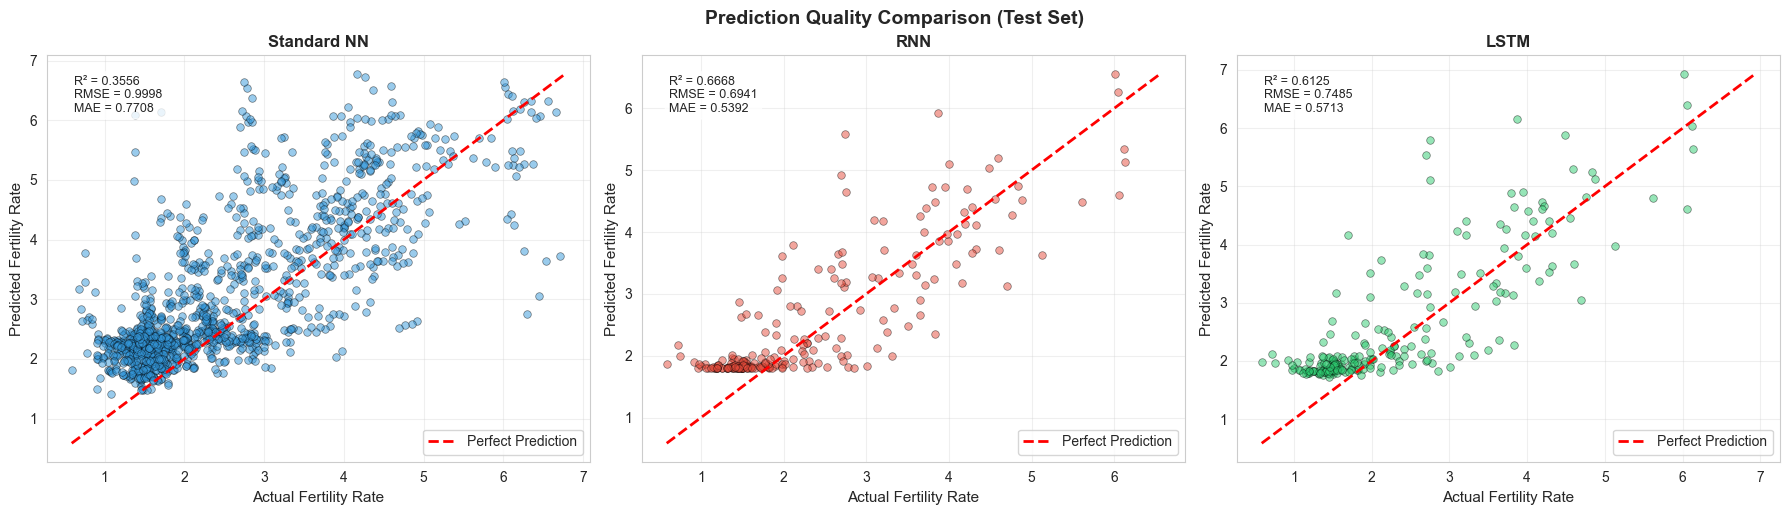

In [32]:
# Side-by-side prediction plots for test set
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, color) in enumerate(zip(models, colors)):
    y_true = models_data[model_name]['test']['y_true']
    y_pred = models_data[model_name]['test']['y_pred']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.5, s=30, color=color, edgecolor='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Fertility Rate', fontsize=11)
    axes[idx].set_ylabel('Predicted Fertility Rate', fontsize=11)
    axes[idx].set_title(f'{model_name}', fontweight='bold', fontsize=12)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    
    # Add metrics text box
    test_metrics = extended_metrics[model_name]['test']
    text_str = f"R² = {test_metrics['r2']:.4f}\nRMSE = {test_metrics['rmse']:.4f}\nMAE = {test_metrics['mae']:.4f}"
    axes[idx].text(0.05, 0.95, text_str,
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)

plt.tight_layout()
plt.suptitle('Prediction Quality Comparison (Test Set)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

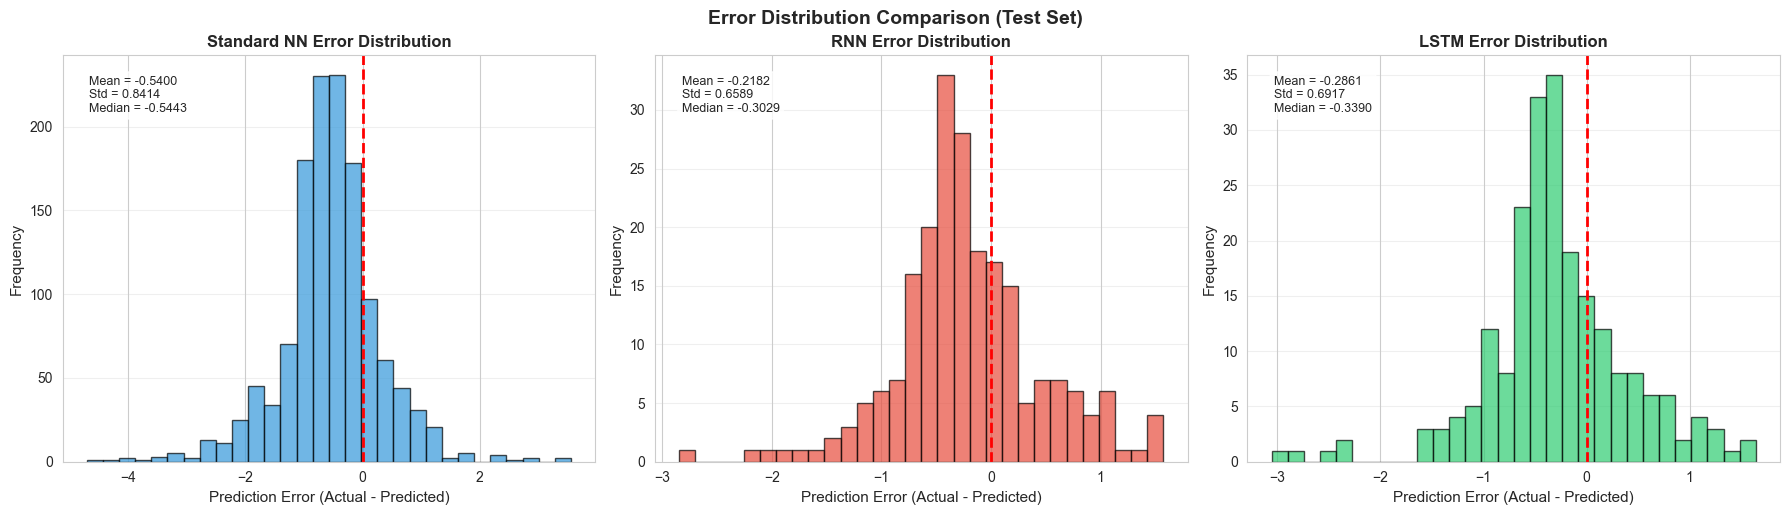

In [33]:
# Error distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, color) in enumerate(zip(models, colors)):
    y_true = models_data[model_name]['test']['y_true']
    y_pred = models_data[model_name]['test']['y_pred']
    errors = y_true - y_pred
    
    axes[idx].hist(errors, bins=30, color=color, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{model_name} Error Distribution', fontweight='bold', fontsize=12)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add statistics
    text_str = f"Mean = {errors.mean():.4f}\nStd = {errors.std():.4f}\nMedian = {np.median(errors):.4f}"
    axes[idx].text(0.05, 0.95, text_str,
                   transform=axes[idx].transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   fontsize=9)

plt.tight_layout()
plt.suptitle('Error Distribution Comparison (Test Set)', y=1.02, fontsize=14, fontweight='bold')
plt.show()

## 6. Model Training Efficiency

In [34]:
# Training efficiency comparison
training_data = []

configs = {
    'Standard NN': standard_nn_metrics['model_config'],
    'RNN': rnn_metrics['model_config'],
    'LSTM': lstm_metrics['model_config']
}

for model_name, config in configs.items():
    training_data.append({
        'Model': model_name,
        'Total Epochs': config['total_epochs'],
        'Best Epoch': config['best_epoch'],
        'Batch Size': config['batch_size'],
        'Learning Rate': config['learning_rate'],
        'Optimizer': config['optimizer']
    })

training_df = pd.DataFrame(training_data)

print("\nMODEL TRAINING EFFICIENCY:")
print("="*80)
print(training_df.to_string(index=False))
print("\nNote: Lower 'Total Epochs' means model converged faster (early stopping kicked in)")


MODEL TRAINING EFFICIENCY:
      Model  Total Epochs  Best Epoch  Batch Size  Learning Rate Optimizer
Standard NN           152         132          32         0.0010      Adam
        RNN            56          31          32         0.0010      Adam
       LSTM            52          27          32         0.0010      Adam

Note: Lower 'Total Epochs' means model converged faster (early stopping kicked in)


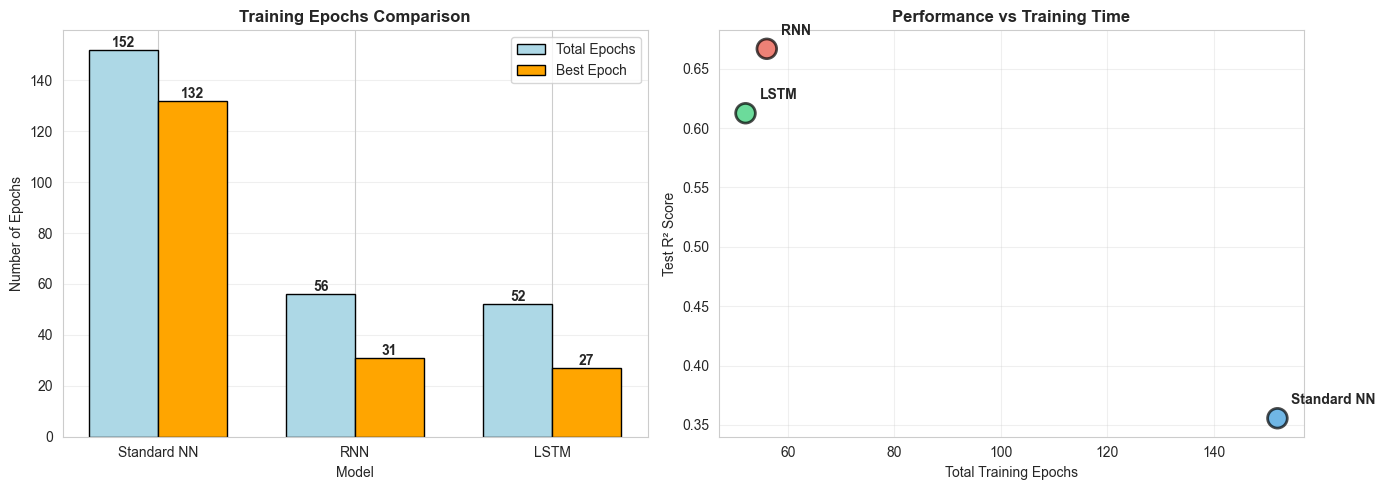

In [35]:
# Visualize training efficiency
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Epochs comparison
x = np.arange(len(models))
total_epochs = [configs[model]['total_epochs'] for model in models]
best_epochs = [configs[model]['best_epoch'] for model in models]

width = 0.35
bars1 = axes[0].bar(x - width/2, total_epochs, width, label='Total Epochs', color='lightblue', edgecolor='black')
bars2 = axes[0].bar(x + width/2, best_epochs, width, label='Best Epoch', color='orange', edgecolor='black')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('Number of Epochs')
axes[0].set_title('Training Epochs Comparison', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold')

# Performance vs Training Time
test_r2 = [extended_metrics[model]['test']['r2'] for model in models]
axes[1].scatter(total_epochs, test_r2, s=200, c=colors, alpha=0.7, edgecolor='black', linewidth=2)

for i, model in enumerate(models):
    axes[1].annotate(model, (total_epochs[i], test_r2[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontweight='bold', fontsize=10)

axes[1].set_xlabel('Total Training Epochs')
axes[1].set_ylabel('Test R² Score')
axes[1].set_title('Performance vs Training Time', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Final Rankings & Recommendations

In [36]:
# Rank models by different criteria
print("="*100)
print("MODEL RANKINGS (TEST SET)")
print("="*100)

ranking_criteria = [
    ('r2', 'R² Score', True),
    ('rmse', 'RMSE', False),
    ('mae', 'MAE', False),
    ('mape', 'MAPE', False),
    ('accuracy_±0.5', 'Accuracy ±0.5', True),
    ('accuracy_±1.0', 'Accuracy ±1.0', True)
]

rankings = {}

for metric_key, metric_name, higher_better in ranking_criteria:
    values = [(model, extended_metrics[model]['test'][metric_key]) for model in models]
    sorted_values = sorted(values, key=lambda x: x[1], reverse=higher_better)
    
    print(f"\n{metric_name}:")
    for rank, (model, value) in enumerate(sorted_values, 1):
        medal = ['🥇', '🥈', '🥉'][rank-1] if rank <= 3 else '  '
        print(f"  {medal} {rank}. {model:15s} = {value:.4f}")
        
        if model not in rankings:
            rankings[model] = []
        rankings[model].append(rank)

# Overall ranking (average rank)
print("\n" + "="*100)
print("OVERALL RANKING (by average rank across all metrics):")
print("="*100)

avg_rankings = [(model, np.mean(ranks)) for model, ranks in rankings.items()]
avg_rankings.sort(key=lambda x: x[1])

for overall_rank, (model, avg_rank) in enumerate(avg_rankings, 1):
    medal = ['🥇', '🥈', '🥉'][overall_rank-1]
    print(f"  {medal} {overall_rank}. {model:15s} (avg rank: {avg_rank:.2f})")

print("\n" + "="*100)

MODEL RANKINGS (TEST SET)

R² Score:
  🥇 1. RNN             = 0.6668
  🥈 2. LSTM            = 0.6125
  🥉 3. Standard NN     = 0.3556

RMSE:
  🥇 1. RNN             = 0.6941
  🥈 2. LSTM            = 0.7485
  🥉 3. Standard NN     = 0.9998

MAE:
  🥇 1. RNN             = 0.5392
  🥈 2. LSTM            = 0.5713
  🥉 3. Standard NN     = 0.7708

MAPE:
  🥇 1. RNN             = 28.2278
  🥈 2. LSTM            = 30.1814
  🥉 3. Standard NN     = 39.5140

Accuracy ±0.5:
  🥇 1. LSTM            = 56.2212
  🥈 2. RNN             = 55.7604
  🥉 3. Standard NN     = 39.0937

Accuracy ±1.0:
  🥇 1. RNN             = 88.0184
  🥈 2. LSTM            = 85.7143
  🥉 3. Standard NN     = 75.3456

OVERALL RANKING (by average rank across all metrics):
  🥇 1. RNN             (avg rank: 1.17)
  🥈 2. LSTM            (avg rank: 1.83)
  🥉 3. Standard NN     (avg rank: 3.00)



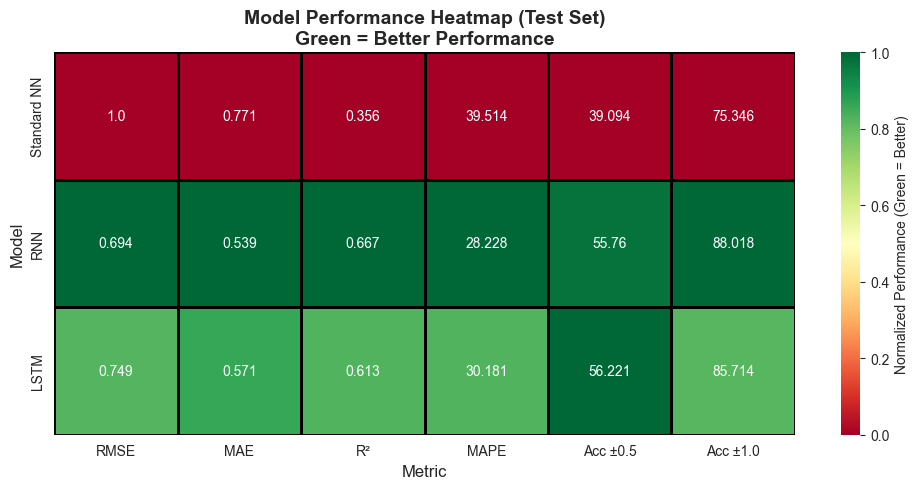


Note: Values shown are actual metrics, colors are normalized for comparison


In [37]:
# Create summary heatmap
heatmap_data = []
metric_names = ['RMSE', 'MAE', 'R²', 'MAPE', 'Acc ±0.5', 'Acc ±1.0']
metric_keys = ['rmse', 'mae', 'r2', 'mape', 'accuracy_±0.5', 'accuracy_±1.0']

for model in models:
    row = []
    for key in metric_keys:
        row.append(extended_metrics[model]['test'][key])
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=models, columns=metric_names)

# Normalize for better visualization
heatmap_normalized = heatmap_df.copy()
for col in heatmap_df.columns:
    if col in ['RMSE', 'MAE', 'MAPE']:  # Lower is better
        heatmap_normalized[col] = 1 - (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())
    else:  # Higher is better
        heatmap_normalized[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())

plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_normalized, annot=heatmap_df.round(3), fmt='', cmap='RdYlGn', 
            cbar_kws={'label': 'Normalized Performance (Green = Better)'},
            linewidths=1, linecolor='black')
plt.title('Model Performance Heatmap (Test Set)\nGreen = Better Performance', fontweight='bold', fontsize=14)
plt.ylabel('Model', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.tight_layout()
plt.show()

print("\nNote: Values shown are actual metrics, colors are normalized for comparison")

## 8. Key Insights & Conclusions

In [38]:
print("="*100)
print("KEY INSIGHTS & CONCLUSIONS")
print("="*100)

# Find best model for each metric
best_models = {}
for metric_key, metric_name, higher_better in ranking_criteria:
    values = {model: extended_metrics[model]['test'][metric_key] for model in models}
    if higher_better:
        best_model = max(values, key=values.get)
    else:
        best_model = min(values, key=values.get)
    best_models[metric_name] = best_model

print("\n1. BEST PERFORMERS BY METRIC:")
for metric_name, best_model in best_models.items():
    print(f"   - {metric_name}: {best_model}")

print("\n2. OVERALL WINNER:")
winner = avg_rankings[0][0]
winner_metrics = extended_metrics[winner]['test']
print(f"   🏆 {winner}")
print(f"      - Test R²: {winner_metrics['r2']:.4f}")
print(f"      - Test RMSE: {winner_metrics['rmse']:.4f}")
print(f"      - Test MAE: {winner_metrics['mae']:.4f}")
print(f"      - Accuracy ±0.5: {winner_metrics['accuracy_±0.5']:.2f}%")

print("\n3. TRAINING EFFICIENCY:")
fastest = min(configs.items(), key=lambda x: x[1]['total_epochs'])
print(f"   - Fastest convergence: {fastest[0]} ({fastest[1]['total_epochs']} epochs)")

print("\n4. GENERALIZATION (Train vs Test R²):")
for model in models:
    train_r2 = extended_metrics[model]['train']['r2']
    test_r2 = extended_metrics[model]['test']['r2']
    gap = train_r2 - test_r2
    print(f"   - {model}: Train R²={train_r2:.4f}, Test R²={test_r2:.4f}, Gap={gap:.4f}")

print("\n5. RECOMMENDATION:")
print(f"   Based on overall performance across multiple metrics, {winner}")
print(f"   is recommended for fertility rate prediction.")

# Identify what each model does best
print("\n6. MODEL STRENGTHS:")
for model in models:
    strengths = [metric for metric, best in best_models.items() if best == model]
    if strengths:
        print(f"   - {model}: Best at {', '.join(strengths)}")

print("\n" + "="*100)

KEY INSIGHTS & CONCLUSIONS

1. BEST PERFORMERS BY METRIC:
   - R² Score: RNN
   - RMSE: RNN
   - MAE: RNN
   - MAPE: RNN
   - Accuracy ±0.5: LSTM
   - Accuracy ±1.0: RNN

2. OVERALL WINNER:
   🏆 RNN
      - Test R²: 0.6668
      - Test RMSE: 0.6941
      - Test MAE: 0.5392
      - Accuracy ±0.5: 55.76%

3. TRAINING EFFICIENCY:
   - Fastest convergence: LSTM (52 epochs)

4. GENERALIZATION (Train vs Test R²):
   - Standard NN: Train R²=0.9022, Test R²=0.3556, Gap=0.5466
   - RNN: Train R²=0.8257, Test R²=0.6668, Gap=0.1589
   - LSTM: Train R²=0.8748, Test R²=0.6125, Gap=0.2622

5. RECOMMENDATION:
   Based on overall performance across multiple metrics, RNN
   is recommended for fertility rate prediction.

6. MODEL STRENGTHS:
   - RNN: Best at R² Score, RMSE, MAE, MAPE, Accuracy ±1.0
   - LSTM: Best at Accuracy ±0.5



## 9. Save Comparison Results

In [39]:
# Save comprehensive comparison report
comparison_report = {
    'extended_metrics': extended_metrics,
    'rankings': {model: ranks for model, ranks in rankings.items()},
    'best_performers': best_models,
    'overall_winner': winner,
    'training_configs': configs
}

import json
with open(f'{model_dir}/model_comparison_report.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    json.dump(comparison_report, f, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, np.integer)) else str(x))

# Save comparison table as CSV
comparison_df.to_csv(f'{model_dir}/model_comparison_table.csv', index=False)

print("Comparison results saved!")
print(f"  - Full report: {model_dir}/model_comparison_report.json")
print(f"  - Comparison table: {model_dir}/model_comparison_table.csv")

Comparison results saved!
  - Full report: ../models/model_comparison_report.json
  - Comparison table: ../models/model_comparison_table.csv
